<a href="https://drive.google.com/file/d/1b7tSyJBpWggHEBGdWa80JdKh7VNq2FEf/view?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chisquare
from collections import Counter
from itertools import permutations


def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

# setting the seed
rng.current = 1
samples = [rng() for _ in range(1000)]

## Serial test

Idea: break the sequence $x_1, x_2, x_3, ..., x_{2n}$ into consecutive series of length $2$: $(x_1, x_2), (x_3, x_4), ..., (x_{2n-1}, x_{2n})$ and look at each element as a random and independent point in $2D$ space. Next, apply chi-square. Similarly, one can construct series of length $3, 4$, etc.

### Problem 1
Implement serial test and apply to a `samples`

Chi-square = 100.4000, p-value = 0.0710


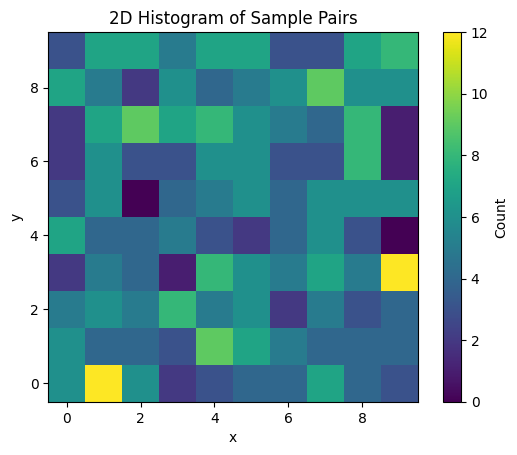

In [80]:
def serial_2d_test(samples, bins=10):
    pairs = np.array(samples[:len(samples) // 2 * 2]).reshape(-1, 2)
    hist, xedges, yedges = np.histogram2d(pairs[:, 0], pairs[:, 1], bins=bins)
    expected = np.ones_like(hist) * hist.mean()
    chi2 = ((hist - expected) ** 2 / expected).sum()
    dof = (bins - 1) ** 2
    p_value = 1 - stats.chi2.cdf(chi2, dof)
    return chi2, p_value, hist

# Run the test
chi2_val, p_val, hist2d = serial_2d_test(samples)
print(f"Chi-square = {chi2_val:.4f}, p-value = {p_val:.4f}")

# Visualization
plt.imshow(hist2d, interpolation='nearest', origin='lower')
plt.title('2D Histogram of Sample Pairs')
plt.colorbar(label='Count')
plt.xlabel('x')
plt.ylabel('y')
plt.show()



### Permutation test

We again decompose the sequence $x_1, x_2, x_3, ..., x_{dn}$ into consecutive series of length $d$: $(x_1, ..., x_d), (x_{d+1}, x_{2d+d}), \ldots, (x_{nd-d+1}, x_{nd})$. A series of $d$ elements can be ordered in $d!$ ways and each way of ordering is equally probable. Hence the idea of the test is to count how many times each ordering occurs among $n$ series and apply the $\chi^2$ test.

### Problem 2*
Implement permutation test and apply to a `samples`

In [81]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

# setting the seed
rng.current = 1
samples = [rng() for _ in range(1000)]


def permutation_test(samples, d=3):
    if len(samples) < d:
        raise ValueError("Sample too short for given d")

    all_perms = list(permutations(range(d)))
    perm_indices = {p: i for i, p in enumerate(all_perms)}

    chunks = [samples[i:i + d] for i in range(0, len(samples) - d + 1, d)]
    chunks = [c for c in chunks if len(c) == d]  # filter valid chunks

    counts = np.zeros(len(all_perms), dtype=int)
    for chunk in chunks:
        order = tuple(np.argsort(chunk))
        idx = perm_indices[order]
        counts[idx] += 1

    total_count = counts.sum()
    expected = np.array([total_count / len(all_perms)] * len(all_perms))

    expected = expected.round(10)

    result = chisquare(counts, expected)
    return result

if __name__ == "__main__":
    result = permutation_test(samples, d=3)
    print(f"Chi-square = {result.statistic:.4f}, p-value = {result.pvalue:.4f}")

Chi-square = 4.8559, p-value = 0.4337


The choice of parameters $m$, $a$ and $c$ has a significant impact on the quality of the sequence. If the parameters are chosen unsuccessfully, it can lead to unexpected consequences:

In [82]:
def rng_bad(m=2**31, a=65539, c=0):
    rng_bad.current = (a * rng_bad.current + c) % m
    return rng_bad.current / m
rng_bad.current = 1

random = [rng_bad() for _ in range(30000)]
print("This sequence looks as random:")
random[:10]

This sequence looks as random:


[3.051897510886192e-05,
 0.00018310965970158577,
 0.0008239871822297573,
 0.003295936156064272,
 0.012359732296317816,
 0.04449496837332845,
 0.15573221957311034,
 0.533938602078706,
 0.8020416363142431,
 0.006802399177104235]

The histogram of the distribution is similar to a uniform distribution:

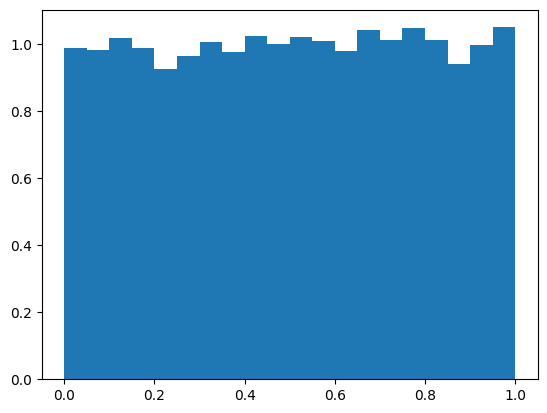

In [83]:
import matplotlib.pyplot as plt
fig = plt.figure()

plt.hist(random, 20, density=True)
plt.show()

However, the series test shows that the points are located on hyperplanes, which does not fit well with the notion of randomness:

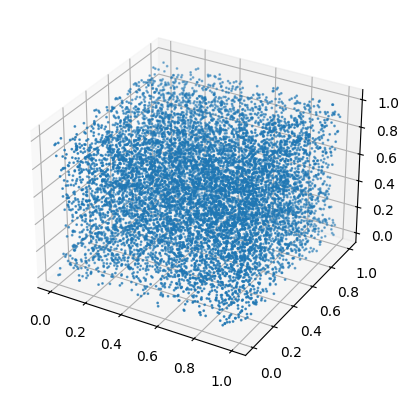

In [84]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(random[::3], random[1::3], random[2::3], s=1)
plt.show()

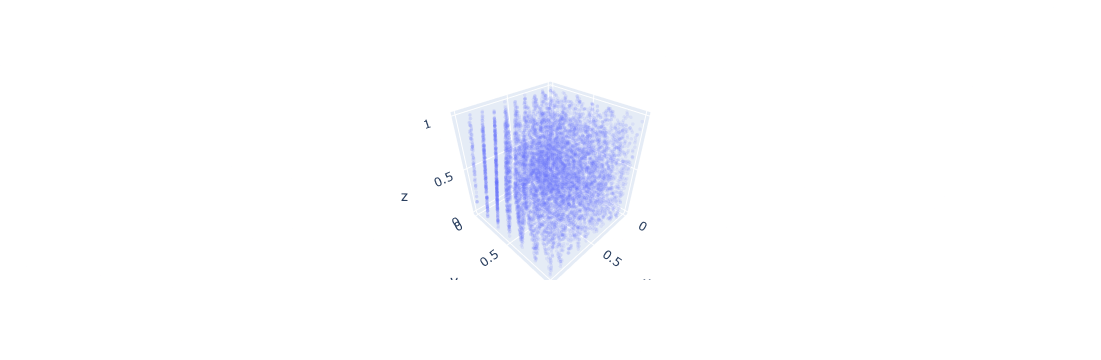

In [85]:
import plotly.express as px
import pandas as pd
fig = px.scatter_3d(x=random[::3], y=random[1::3], z=random[2::3], opacity=0.1)
fig.update_traces(marker_size = 2)
fig.show()

### Problem 3

Provide a statistical test to show that `rng_bad` has problems but `rng_good` does not.

In [86]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 1

def rng_bad(m=2**31, a=65539, c=0):
    rng_bad.current = (a * rng_bad.current + c) % m
    return rng_bad.current / m
rng_bad.current = 1


samples1 = np.array([rng() for _ in range(1000)])
samples2 = np.array([rng_bad() for _ in range(1000)])
chi2_val1, p_val1, hist2d1 = serial_2d_test(samples1)
print(f"Chi-square = {chi2_val1:.4f}, p-value = {p_val1:.4f}")
chi2_val2, p_val2, hist2d2 = serial_2d_test(samples2)
print(f"Chi-square = {chi2_val2:.4f}, p-value = {p_val2:.4f}")

Chi-square = 100.4000, p-value = 0.0710
Chi-square = 124.0000, p-value = 0.0015


* More randomness tests - [Diehard tests](https://en.wikipedia.org/wiki/Diehard_tests).
* More methods for generating a uniform value [here](https://en.wikipedia.org/wiki/List_of_random_number_generators).
* A story about dynamical systems and the transition to chaos https://www.youtube.com/watch?v=ovJcsL7vyrk&feature=youtu.be

# Generating a sample from a given distribution

Suppose we have a random number generator from the segment [0, 1] (use the `np.random.rand()` function for this). How to get a sample from another distribution $F$?

### Problem 4
Simulate a sample of 1000 from a discrete distribution on a set of digits $0, 1, 2, \ldots, 9$ with weights $0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2$. Construct a histogram from the sample. Optimise the algorithm by ordering the weights.

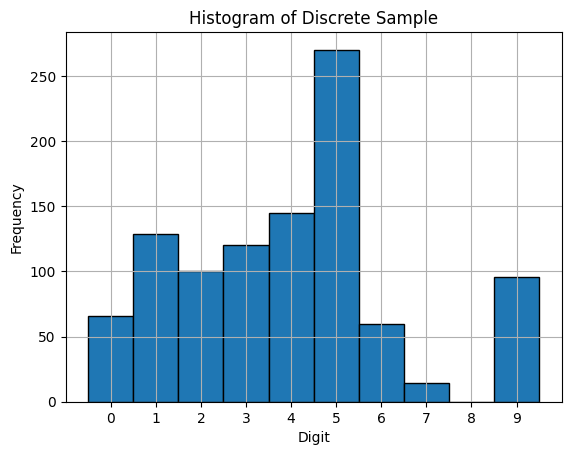

In [99]:
import numpy as np
import matplotlib.pyplot as plt

def sample_discrete(weights, size=1000):
    weights = np.array(weights)
    weights = weights / weights.sum()
    edges = np.cumsum(weights)
    r = np.random.rand(size)
    result = np.searchsorted(edges, r)
    return result

weights = [0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2]
sample = sample_discrete(weights)

plt.hist(sample, bins=np.arange(11)-0.5, edgecolor="black")
plt.xticks(np.arange(10))
plt.title("Histogram of Discrete Sample")
plt.xlabel("Digit")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


## Inverse transform method

The following proposition is the idea behind the *inverse transform* method:

If $\xi$ has a uniform distribution in $[0,1]$, then $F^{-1}(\xi)$ is distributed according to the law of $F$. (For which $F$ is this true?)

### Problem 5
Simulate a sample of size 1000 from the distribution $\operatorname{Exp}(\lambda)$ using the Inverse transform method. Construct a sample histogram and an accurate plot of the distribution density.

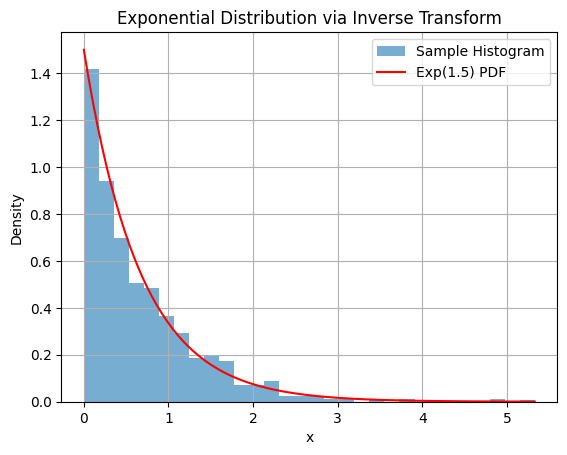

In [100]:
import numpy as np
import matplotlib.pyplot as plt

def inverse_transform_exp(size=1000, lam=1.0):
    u = np.random.rand(size)
    return -np.log(1 - u) / lam

lam = 1.5
exp_sample = inverse_transform_exp(size=1000, lam=lam)

x = np.linspace(0, np.max(exp_sample), 200)
true_pdf = lam * np.exp(-lam * x)

plt.hist(exp_sample, bins=30, density=True, alpha=0.6, label="Sample Histogram")
plt.plot(x, true_pdf, 'r-', label=f"Exp({lam}) PDF")
plt.title("Exponential Distribution via Inverse Transform")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

## Rejection sampling (Accept-reject method)

The idea of the method is to sample from the distribution we know how to sample from, and then select points that follow the desired distribution. More precisely: let's say we know how to sample from a distribution with density $p$, and we want to sample from a distribution with density $\pi$. Let's take a random $x$ from the distribution $p$. Then take $y$ uniformly distributed on the interval $[0, p(x)]$. If the point $(x, y)$ falls under the graph of $\pi$, we take $x$ as a sampling element from $\pi$. If not, we repeat the procedure for a new $x$. The picture illustrates the idea of the method (the densities are normalised so that one lies entirely under the other):

<img src=https://colcarroll.github.io/hamiltonian_monte_carlo_talk/images/bayes_talk.015.png style="width: 50%;"/>

### Problem 6
Justify (orally) that the accept-reject method really samples from the required distribution. Simulate $1000$ points from the distribution with density $e^xcos^2x \cdot \mathbb{I}_{[-\frac\pi2, \frac\pi2]}$. Plot the sampled histogram on the sample and compare it with the plot of the exact density function.

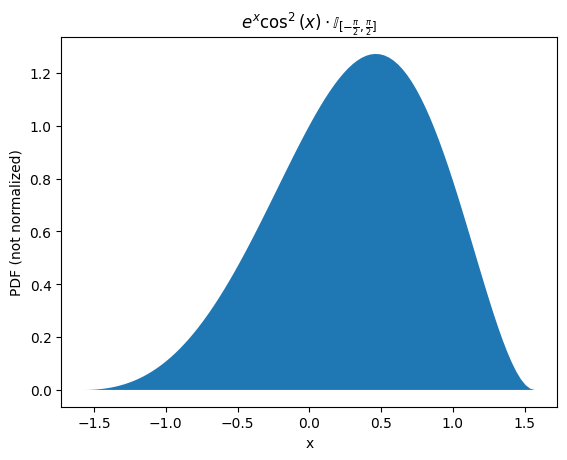

In [89]:
fig = plt.figure()

x = np.linspace(-np.pi/2, np.pi/2, 100)
density = np.exp(x) * np.cos(x) ** 2 # not normalized density!
plt.fill_between(x, 0, density)
plt.ylabel('PDF (not normalized)')
plt.xlabel('x')
plt.title(r'$e^x \cos^2(x) \cdot \mathbb{I}_{[-\frac{\pi}{2}, \frac{\pi}{2}]}$')

plt.show()

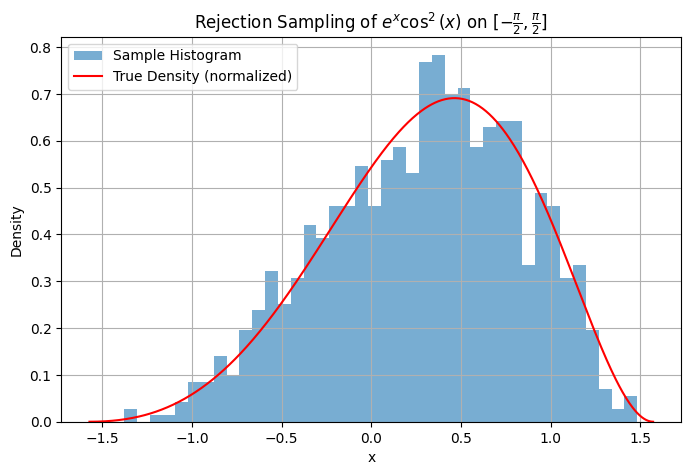

In [104]:
# Обоснование:
# Метод отбраковки работает, потому что мы случайным образом выбираем точки (x, y)
# под прямоугольником, и оставляем только те, что попадают под график плотности f(x).
# Вероятность принятия x пропорциональна значению f(x),
# поэтому итоговое распределение принятого x совпадает с формой f(x).

import numpy as np
import matplotlib.pyplot as plt

def target_density(x):
    return np.exp(x) * np.cos(x)**2

def rejection_sample(size=1000):
    samples = []
    max_density = 1.3
    while len(samples) < size:
        x = np.random.uniform(-np.pi/2, np.pi/2)
        y = np.random.uniform(0, max_density)
        if y < target_density(x):
            samples.append(x)
    return np.array(samples)

rejected_sample = rejection_sample(1000)

x = np.linspace(-np.pi/2, np.pi/2, 500)
density = target_density(x)

plt.figure(figsize=(8, 5))
plt.hist(rejected_sample, bins=40, density=True, alpha=0.6, label="Sample Histogram")
plt.plot(x, density / np.trapezoid(density, x), 'r-', label="True Density (normalized)")
plt.xlabel("x")
plt.ylabel("Density")
plt.title(r"Rejection Sampling of $e^x \cos^2(x)$ on $[-\frac{\pi}{2}, \frac{\pi}{2}]$")
plt.legend()
plt.grid(True)
plt.show()



## Coordinate transformation method

The accept-reject method may in some cases be inefficient and require too many sample points. An alternative is to try to find a coordinate transformation that converts a simple area (from which it is easy to sample, for example, a unit square) into the required area, but preserves the area ratio (why?).

### Problem 7
Model and depict a sample of 500 points uniformly distributed within a given triangle without using a selection method.

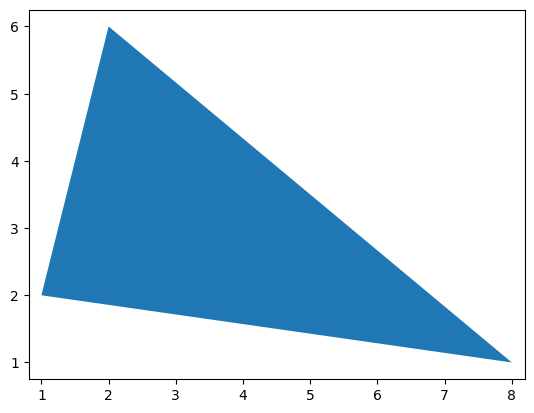

In [91]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

fig = plt.figure()

polygon = Polygon(xy=np.array([[1, 2], [2, 6], [8, 1]]), closed=True)
plt.gca().add_collection(PatchCollection([polygon]))
plt.axis('equal')
plt.show()

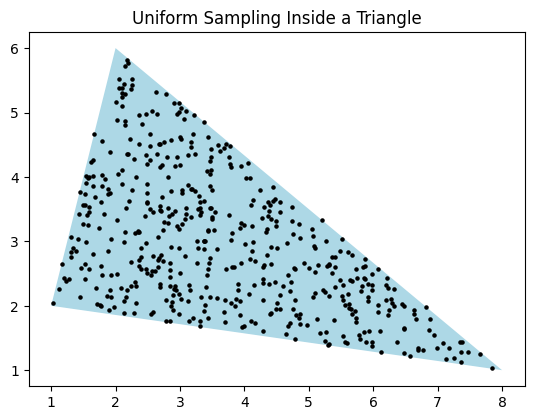

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

v1 = np.array([1, 2])
v2 = np.array([2, 6])
v3 = np.array([8, 1])

def uniform_in_triangle(v1, v2, v3, n=500):
    u = np.random.rand(n)
    v = np.random.rand(n)
    flip = u + v > 1
    u[flip] = 1 - u[flip]
    v[flip] = 1 - v[flip]
    return (1 - u - v)[:, None] * v1 + u[:, None] * v2 + v[:, None] * v3

points = uniform_in_triangle(v1, v2, v3, 500)

fig, ax = plt.subplots()
polygon = Polygon([v1, v2, v3], closed=True)
ax.add_collection(PatchCollection([polygon], facecolor='lightblue'))
ax.scatter(points[:, 0], points[:, 1], color='black', s=5)
ax.set_aspect('equal')
plt.title("Uniform Sampling Inside a Triangle")
plt.show()


### Problem 8
Model without using the selection method a sample of $500$ points uniformly distributed inside the unit circle. Picture the obtained points. Do they really fill the circle uniformly?

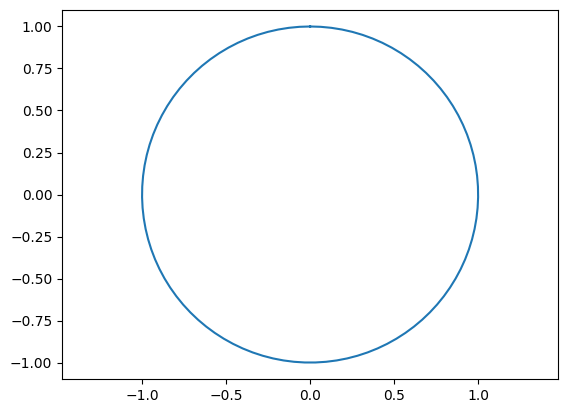

In [93]:
fig = plt.figure()

t = np.linspace(0, 2*np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.show()

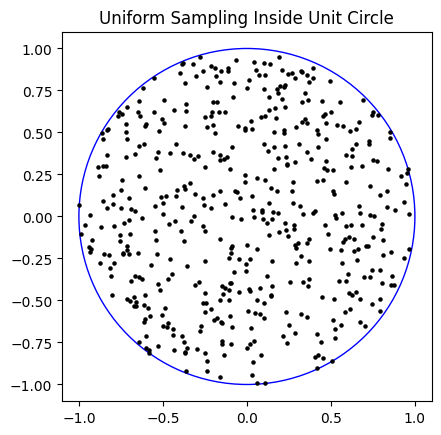

In [106]:
import numpy as np
import matplotlib.pyplot as plt

n = 500
r = np.sqrt(np.random.rand(n))
theta = 2 * np.pi * np.random.rand(n)

x = r * np.cos(theta)
y = r * np.sin(theta)

fig, ax = plt.subplots()
circle = plt.Circle((0, 0), 1, edgecolor='blue', facecolor='none')
ax.add_patch(circle)
ax.scatter(x, y, color='black', s=5)
ax.set_aspect('equal')
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
plt.title("Uniform Sampling Inside Unit Circle")
plt.show()


# Random normal generator

### Problem 9
Prove (orally) that the following algorithm (**Box-Muller algorithm**, https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform) generates a sample of independent $\mathcal{N}(0,1)$ random variables. Modify the method to exclude calls of trigonometric functions `np.sin` and `np.cos`. Using the modified method, simulate a sample size of $1000$ from a $2D$ Gaussian distribution with mean $\mu$ and covariance matrix $\Sigma$, where
$$\mu = \begin{pmatrix} 4 \\ 7 \end{pmatrix}^T, \quad \Sigma = \begin{pmatrix} 20 & -4 \\ -4 & 40 \end{pmatrix}.$$
Construct a 2D histogram of the resulting distribution. Compare the sample mean and covariance matrix with the exact values.

In [107]:
import seaborn as sns

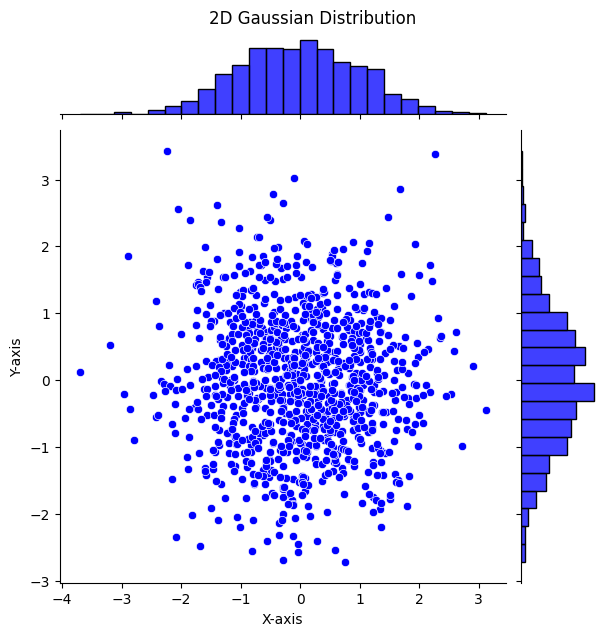

In [110]:
n = 1000
u1, u2 = np.random.rand(2, n)
r = np.sqrt(-2 * np.log(u1))
theta = 2 * np.pi * u2
x = r * np.cos(theta)
y = r * np.sin(theta)


joint_plot = sns.jointplot(x=x, y=y, color="blue")
joint_plot.set_axis_labels('X-axis', 'Y-axis')
plt.suptitle('2D Gaussian Distribution', y=1.02)
plt.show()

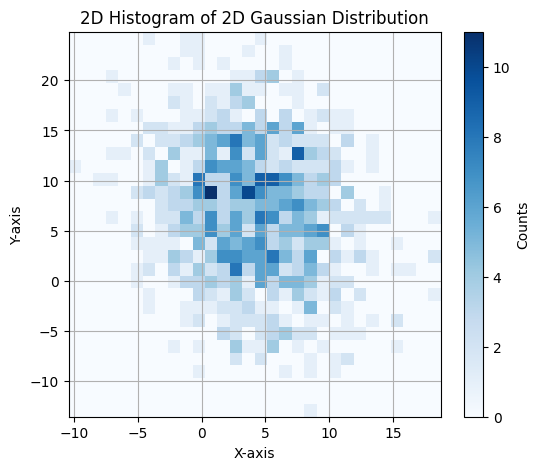

Sample mean: [4.11588523 6.93273332]
Sample covariance:
 [[18.9077465  -4.84965701]
 [-4.84965701 42.75627059]]


In [114]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def box_muller_polar(n):
    x = []
    y = []
    while len(x) < n:
        u, v = np.random.uniform(-1, 1, 2)
        s = u**2 + v**2
        if 0 < s < 1:
            factor = np.sqrt(-2 * np.log(s) / s)
            x.append(u * factor)
            y.append(v * factor)
    return np.array(x[:n]), np.array(y[:n])

n = 1000
z1, z2 = box_muller_polar(n)

mu = np.array([4, 7])
Sigma = np.array([[20, -4], [-4, 40]])
L = np.linalg.cholesky(Sigma)
z = np.vstack([z1, z2])
samples = (mu[:, None] + L @ z).T

plt.figure(figsize=(6, 5))
plt.hist2d(samples[:, 0], samples[:, 1], bins=30, cmap='Blues')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Histogram of 2D Gaussian Distribution')
plt.colorbar(label='Counts')
plt.grid(True)
plt.show()

print("Sample mean:", np.mean(samples, axis=0))
print("Sample covariance:\n", np.cov(samples.T))


### Problem 10*

Implement a method of generating a random partition of an n-element set into subsets. Use it to estimate the expected number of subsets in a random partition of a set of 100 elements.

Hint 1: Ширяев, Вероятность, т1, задача 2 к параграфу 1.

Hint 2: http://djalil.chafai.net/blog/2012/05/03/generating-uniform-random-partitions/

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from math import factorial, e

# Bell numbers
def bell_number(n):
    B = [1]
    for i in range(1, n+1):
        total = 0
        for k in range(i):
            total += comb(i-1, k) * B[k]
        B.append(total)
    return B[n]

def comb(n, k):
    return factorial(n) // (factorial(k) * factorial(n - k))

# Sampling number of blocks
def choose_num_blocks(n, Bn=None):
    if Bn is None:
        Bn = bell_number(n)
    r = np.random.rand()
    acc = 0.0
    k = 1
    while True:
        acc += (k**n) / (factorial(k) * Bn * e)
        if r < acc:
            return k
        k += 1

# Assign random labels uniformly from 1 to k
def assign_labels(n, k):
    return np.random.randint(1, k+1, size=n)

# Convert labels to partition groups
def labeled_partition(elements):
    n = len(elements)
    Bn = bell_number(n)
    k = choose_num_blocks(n, Bn)
    labels = assign_labels(n, k)
    partition = {}
    for idx, lbl in enumerate(labels):
        partition.setdefault(lbl, []).append(elements[idx])
    return list(partition.values())

# Estimate expected number of subsets for n=100
n_samples = 1000
n = 100
counts = [len(set(assign_labels(n, choose_num_blocks(n, bell_number(n))))) for _ in range(n_samples)]
print("Estimated expected number of subsets for n=100:", np.mean(counts))

Estimated expected number of subsets for n=100: 28.686


# Basic distributions
- **Uniform distribution $\operatorname{U}[a, b]$**:
$$p(x) = \frac{1}{b-a}\cdot\mathbb{I}_{x\in[a, b]}$$

- **Exponential distribution $\operatorname{Exp}(\lambda)$**:
$$p(x) = \lambda e^{-\lambda x}\cdot\mathbb{I}_{x\geqslant0}$$

- **Normal distribution $\mathcal{N}(\mu, \sigma^2)$**:
$$p(x) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

- **Gamma distribution $\operatorname{Gamma}(\alpha, \lambda)$**:
$$p(x) = \frac{\lambda^\alpha}{\Gamma(\alpha)}x^{\alpha-1}e^{-\lambda x}\cdot\mathbb{I}_{x\geqslant0}$$

- **Beta distribution $\operatorname{Beta}(\alpha, \beta)$**:
$$p(x) = \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}x^{\alpha-1}(1-x)^{\beta-1}\cdot\mathbb{I}_{x\in[0, 1]}$$

- **$\chi^2$ distribution with $k$ degrees of freedom $\chi^2(k)$**:
$$p(x) = \frac{1}{2^{k/2}\Gamma(k/2)}x^{k/2-1}e^{-x/2}\cdot\mathbb{I}_{x\geqslant0}$$



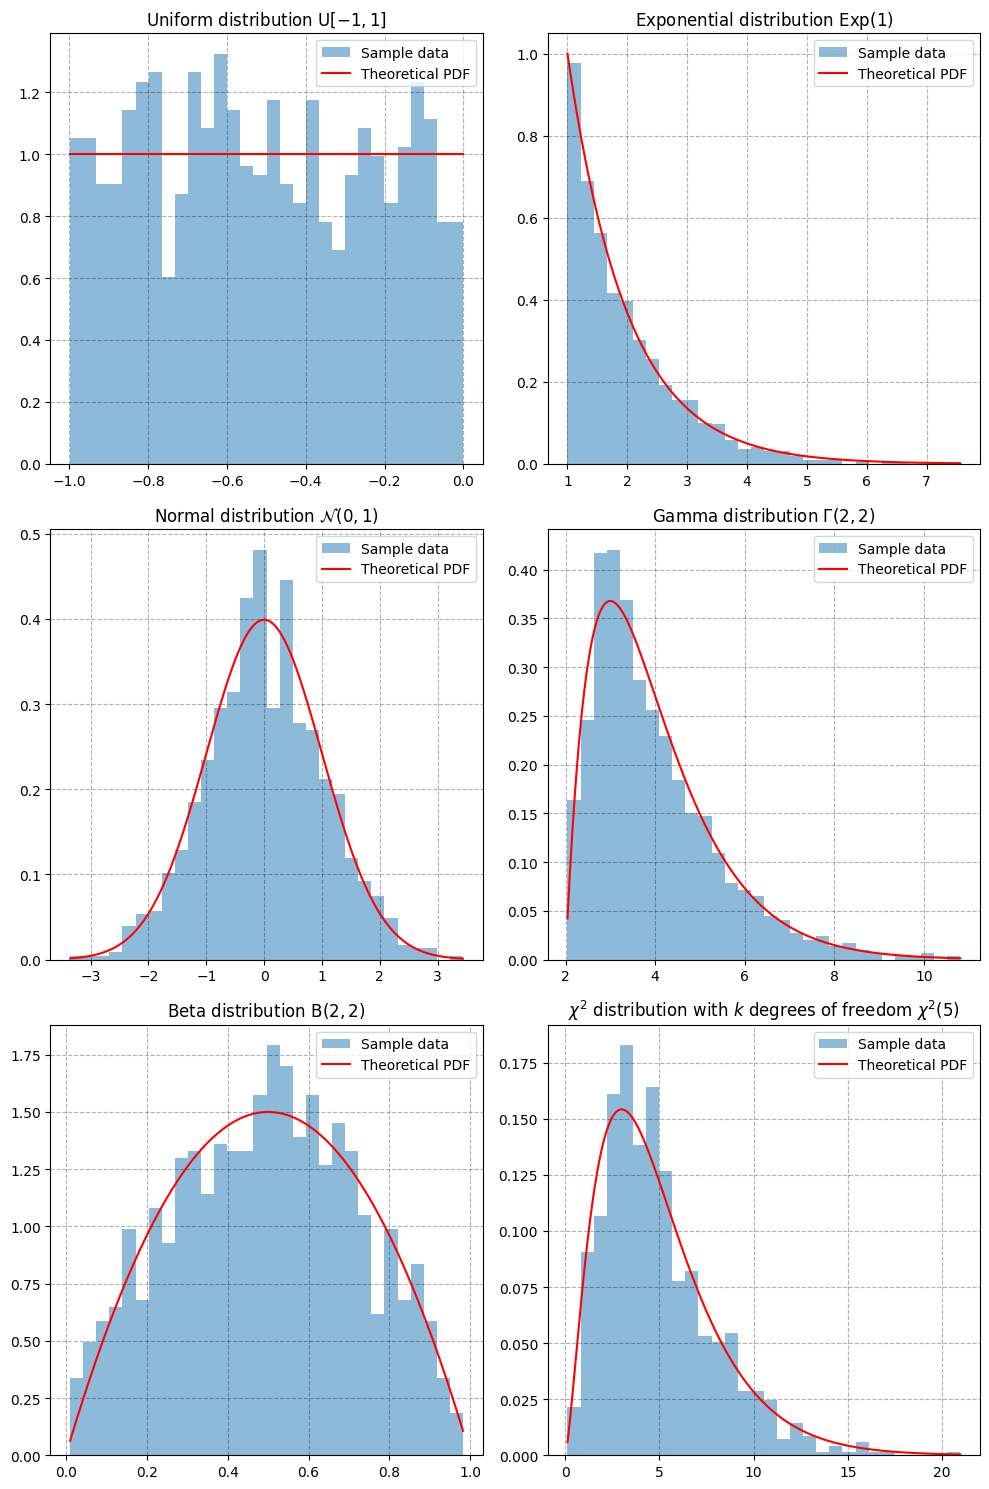

In [116]:
# Define distributions and their parameters
distributions = [
    ("Uniform distribution $\\operatorname{U}[-1, 1]$", stats.uniform, (-1, 1)),
    ("Exponential distribution $\\operatorname{Exp}(1)$", stats.expon, (1,)),
    ("Normal distribution $\\mathcal{N}(0, 1)$", stats.norm, (0, 1)),
    ("Gamma distribution $\\Gamma(2, 2)$", stats.gamma, (2, 2)),
    ("Beta distribution $\\operatorname{B}(2, 2)$", stats.beta, (2, 2)),
    ("$\\chi^2$ distribution with $k$ degrees of freedom $\\chi^2(5)$", stats.chi2, (5,))
]

# Setup the figure and axes for a 2x3 subplot
fig, axs = plt.subplots(3, 2, figsize=(10, 15))  # Adjust figsize according to your needs
axs = axs.flatten()  # Flatten the array to easily iterate over it

for ax, (name, dist, params) in zip(axs, distributions):
    # Generate sample data
    data = dist.rvs(*params, size=1000)
    # Generate points for PDF
    x = np.linspace(min(data), max(data), 1000)
    pdf = dist.pdf(x, *params)

    # Plot histogram of sample data
    ax.hist(data, bins=30, density=True, alpha=0.5, label='Sample data')
    # Plot theoretical PDF
    ax.plot(x, pdf, 'r-', label='Theoretical PDF')
    ax.set_title(name)
    ax.legend()
    ax.grid(linestyle='--', color='black', alpha=0.3)

plt.tight_layout()  # Adjust subplots to fit in the figure area
plt.show()
